# Centralized Federated Learning (FedAvg) Analysis

This notebook analyzes experiments run in **centralized mode** using the FedAvg algorithm.

**Features:**
- Server-client architecture analysis
- Global model performance tracking
- Per-client metrics and fairness analysis
- Convergence and straggler detection
- Data distribution heterogeneity

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Experiment Data

In [2]:
# Specify experiment directory
logs_base = Path('logs')

# Auto-detect latest centralized experiment or specify manually
centralized_dirs = [d for d in logs_base.glob('*') if d.is_dir() and 'centralized' in d.name.lower()]
if centralized_dirs:
    # Get most recent
    experiment_dir = max(centralized_dirs, key=lambda p: p.stat().st_mtime)
    # Or use specific subdirectory with timestamp
    subdirs = sorted([d for d in experiment_dir.iterdir() if d.is_dir()], reverse=True)
    if subdirs:
        experiment_dir = subdirs[0]
else:
    # Manually specify
    experiment_dir = logs_base / 'your_experiment_name' / '2026-02-05_12-00-00'

print(f"Analyzing experiment: {experiment_dir}")
print(f"Experiment path: {experiment_dir.absolute()}")

# Create plots directory
plots_dir = experiment_dir / 'plots'
plots_dir.mkdir(exist_ok=True)
print(f"Plots will be saved to: {plots_dir}")

Analyzing experiment: logs\decentralized_p2p\2026-02-04_14-13-02
Experiment path: c:\Users\asus\Desktop\TREES\tanguy progress\code\FederatedLearningFramework\logs\decentralized_p2p\2026-02-04_14-13-02
Plots will be saved to: logs\decentralized_p2p\2026-02-04_14-13-02\plots


In [3]:
# Load configuration
config_file = experiment_dir / 'config.json'
if config_file.exists():
    with open(config_file, 'r') as f:
        config = json.load(f)
    print("\nExperiment Configuration:")
    for key, value in config.items():
        print(f"  {key}: {value}")
else:
    print("Warning: config.json not found")
    config = {}


Experiment Configuration:
  type: decentralized
  rounds: 5
  epochs: 5
  num_clients: 10
  model: simple_cnn
  dataset: cifar10
  data_dir: ./data
  partition: iid
  alpha: 0.5
  classes_per_client: 2
  lr: 0.01
  momentum: 0.9
  weight_decay: 0.0
  batch_size: 32
  main_link_prob: 1.0
  border_link_prob: 1.0
  intra_cluster_prob: 0.8
  no_cuda: False
  num_workers: 0
  seed: 42
  log_dir: ./logs
  experiment_name: None


In [4]:
# Load CSV files
per_client_file = experiment_dir / 'per_client_metrics.csv'
per_class_file = experiment_dir / 'per_class_metrics.csv'
global_file = experiment_dir / 'global_metrics.csv'
gradient_file = experiment_dir / 'gradient_metrics.csv'
convergence_file = experiment_dir / 'convergence_metrics.csv'
data_dist_file = experiment_dir / 'data_distribution.csv'
round_summary_file = experiment_dir / 'round_summary.csv'

# Load available files
dfs = {}
if per_client_file.exists():
    dfs['per_client'] = pd.read_csv(per_client_file)
    print(f"✓ Loaded per_client_metrics: {len(dfs['per_client'])} records")

if per_class_file.exists():
    dfs['per_class'] = pd.read_csv(per_class_file)
    print(f"✓ Loaded per_class_metrics: {len(dfs['per_class'])} records")

if global_file.exists():
    dfs['global'] = pd.read_csv(global_file)
    print(f"✓ Loaded global_metrics: {len(dfs['global'])} records")

if gradient_file.exists():
    dfs['gradient'] = pd.read_csv(gradient_file)
    print(f"✓ Loaded gradient_metrics: {len(dfs['gradient'])} records")

if convergence_file.exists():
    dfs['convergence'] = pd.read_csv(convergence_file)
    print(f"✓ Loaded convergence_metrics: {len(dfs['convergence'])} records")

if data_dist_file.exists():
    dfs['data_dist'] = pd.read_csv(data_dist_file)
    print(f"✓ Loaded data_distribution: {len(dfs['data_dist'])} records")

if round_summary_file.exists():
    dfs['round_summary'] = pd.read_csv(round_summary_file)
    print(f"✓ Loaded round_summary: {len(dfs['round_summary'])} records")

print(f"\nTotal files loaded: {len(dfs)}")

✓ Loaded global_metrics: 0 records
✓ Loaded round_summary: 5 records

Total files loaded: 2


## 3. Global Model Performance

KeyError: 'global_test_accuracy'

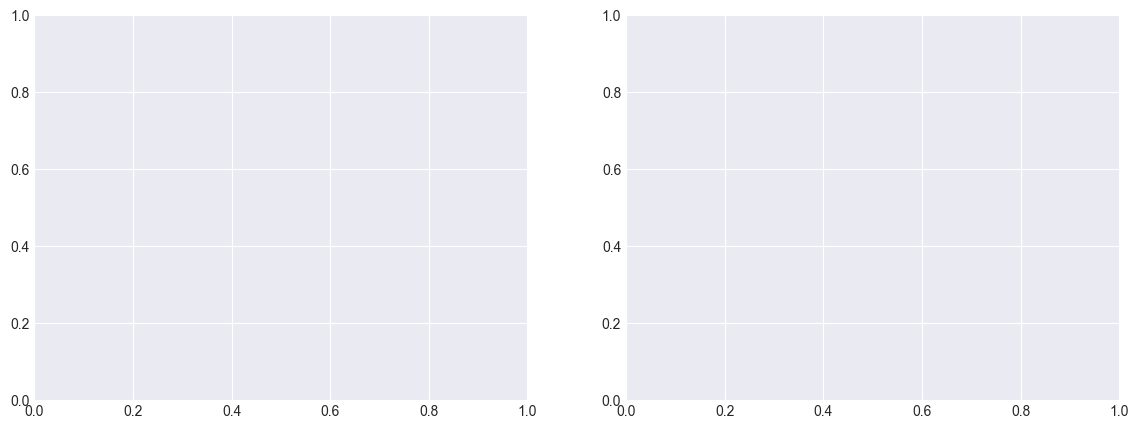

In [5]:
if 'global' in dfs:
    df_global = dfs['global']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Global accuracy
    axes[0].plot(df_global['round'], df_global['global_test_accuracy'], 
                marker='o', linewidth=2, label='Test Accuracy', color='blue')
    axes[0].plot(df_global['round'], df_global['global_train_accuracy'], 
                marker='s', linewidth=2, label='Train Accuracy', color='green', alpha=0.7)
    axes[0].set_xlabel('Round')
    axes[0].set_ylabel('Accuracy (%)')
    axes[0].set_title('Global Model Accuracy Evolution')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Global loss
    axes[1].plot(df_global['round'], df_global['global_test_loss'], 
                marker='o', linewidth=2, label='Test Loss', color='red')
    axes[1].plot(df_global['round'], df_global['global_train_loss'], 
                marker='s', linewidth=2, label='Train Loss', color='orange', alpha=0.7)
    axes[1].set_xlabel('Round')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Global Model Loss Evolution')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(plots_dir / 'global_performance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nFinal Global Performance:")
    print(f"  Test Accuracy: {df_global['global_test_accuracy'].iloc[-1]:.2f}%")
    print(f"  Test Loss: {df_global['global_test_loss'].iloc[-1]:.4f}")
    print(f"  Best Accuracy: {df_global['global_test_accuracy'].max():.2f}% (Round {df_global.loc[df_global['global_test_accuracy'].idxmax(), 'round']:.0f})")
else:
    print("Global metrics not found")

## 4. Per-Client Performance Analysis

In [ ]:
if 'per_client' in dfs:
    df_client = dfs['per_client']
    
    # Get final round data
    final_round = df_client['round'].max()
    final_data = df_client[df_client['round'] == final_round]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Client accuracy evolution
    for client_id in df_client['client_id'].unique():
        client_data = df_client[df_client['client_id'] == client_id]
        # Get last epoch of each round for cleaner visualization
        last_epochs = client_data.groupby('round').last()
        axes[0, 0].plot(last_epochs.index, last_epochs['test_accuracy'], 
                       marker='o', alpha=0.7, label=f'Client {client_id}')
    axes[0, 0].set_xlabel('Round')
    axes[0, 0].set_ylabel('Test Accuracy (%)')
    axes[0, 0].set_title('Per-Client Test Accuracy Evolution')
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Client loss evolution
    for client_id in df_client['client_id'].unique():
        client_data = df_client[df_client['client_id'] == client_id]
        last_epochs = client_data.groupby('round').last()
        axes[0, 1].plot(last_epochs.index, last_epochs['test_loss'], 
                       marker='o', alpha=0.7, label=f'Client {client_id}')
    axes[0, 1].set_xlabel('Round')
    axes[0, 1].set_ylabel('Test Loss')
    axes[0, 1].set_title('Per-Client Test Loss Evolution')
    axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Final round comparison
    final_acc = final_data.groupby('client_id')['test_accuracy'].last()
    axes[1, 0].bar(final_acc.index, final_acc.values, alpha=0.7, color='steelblue')
    axes[1, 0].axhline(final_acc.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {final_acc.mean():.2f}%')
    axes[1, 0].set_xlabel('Client ID')
    axes[1, 0].set_ylabel('Test Accuracy (%)')
    axes[1, 0].set_title(f'Final Test Accuracy by Client (Round {final_round})')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # 4. Accuracy distribution
    axes[1, 1].hist(final_acc.values, bins=15, alpha=0.7, color='green', edgecolor='black')
    axes[1, 1].axvline(final_acc.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    axes[1, 1].axvline(final_acc.median(), color='blue', linestyle='--', linewidth=2, label='Median')
    axes[1, 1].set_xlabel('Test Accuracy (%)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Client Accuracy Distribution')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(plots_dir / 'per_client_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nClient Performance Statistics (Final Round):")
    print(f"  Mean Accuracy: {final_acc.mean():.2f}%")
    print(f"  Std Dev: {final_acc.std():.2f}%")
    print(f"  Min Accuracy: {final_acc.min():.2f}% (Client {final_acc.idxmin()})")
    print(f"  Max Accuracy: {final_acc.max():.2f}% (Client {final_acc.idxmax()})")
    print(f"  Fairness Gap: {final_acc.max() - final_acc.min():.2f}%")
else:
    print("Per-client metrics not found")

## 5. Per-Class Performance Heatmaps

In [ ]:
if 'per_class' in dfs:
    df_class = dfs['per_class']
    
    # Get final round
    final_round = df_class['round'].max()
    final_class_data = df_class[df_class['round'] == final_round]
    
    # Create pivot tables
    precision_pivot = final_class_data.pivot_table(
        values='class_precision', index='client_id', columns='class_id', aggfunc='mean'
    )
    recall_pivot = final_class_data.pivot_table(
        values='class_recall', index='client_id', columns='class_id', aggfunc='mean'
    )
    f1_pivot = final_class_data.pivot_table(
        values='class_f1_score', index='client_id', columns='class_id', aggfunc='mean'
    )
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    sns.heatmap(precision_pivot, annot=True, fmt='.1f', cmap='YlGnBu', 
                ax=axes[0], cbar_kws={'label': 'Precision (%)'})
    axes[0].set_title(f'Precision per Class (Round {final_round})')
    axes[0].set_xlabel('Class ID')
    axes[0].set_ylabel('Client ID')
    
    sns.heatmap(recall_pivot, annot=True, fmt='.1f', cmap='YlOrRd', 
                ax=axes[1], cbar_kws={'label': 'Recall (%)'})
    axes[1].set_title(f'Recall per Class (Round {final_round})')
    axes[1].set_xlabel('Class ID')
    axes[1].set_ylabel('Client ID')
    
    sns.heatmap(f1_pivot, annot=True, fmt='.1f', cmap='Greens', 
                ax=axes[2], cbar_kws={'label': 'F1 Score (%)'})
    axes[2].set_title(f'F1 Score per Class (Round {final_round})')
    axes[2].set_xlabel('Class ID')
    axes[2].set_ylabel('Client ID')
    
    plt.tight_layout()
    plt.savefig(plots_dir / 'per_class_heatmaps.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nAverage Per-Class Metrics:")
    print(f"  Precision: {df_class['class_precision'].mean():.2f}%")
    print(f"  Recall: {df_class['class_recall'].mean():.2f}%")
    print(f"  F1 Score: {df_class['class_f1_score'].mean():.2f}%")
else:
    print("Per-class metrics not found")

## 6. Convergence and Straggler Analysis

In [ ]:
if 'convergence' in dfs:
    df_conv = dfs['convergence']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Stragglers over rounds
    straggler_counts = df_conv.groupby('round')['stragglers_count'].first()
    axes[0, 0].plot(straggler_counts.index, straggler_counts.values, 
                   marker='o', linewidth=2, color='red')
    axes[0, 0].fill_between(straggler_counts.index, straggler_counts.values, alpha=0.3, color='red')
    axes[0, 0].set_xlabel('Round')
    axes[0, 0].set_ylabel('Number of Stragglers')
    axes[0, 0].set_title('Straggler Detection Over Rounds')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Accuracy convergence rate
    axes[0, 1].plot(df_conv['round'], df_conv['accuracy_convergence_rate'], 
                   marker='o', linewidth=2, color='green')
    axes[0, 1].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[0, 1].set_xlabel('Round')
    axes[0, 1].set_ylabel('Convergence Rate')
    axes[0, 1].set_title('Accuracy Convergence Rate')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Client accuracy spread
    axes[1, 0].fill_between(df_conv['round'], 
                            df_conv['client_accuracy_min'], 
                            df_conv['client_accuracy_max'], 
                            alpha=0.3, label='Min-Max Range')
    axes[1, 0].plot(df_conv['round'], df_conv['client_accuracy_mean'], 
                   marker='o', linewidth=2, color='blue', label='Mean')
    axes[1, 0].set_xlabel('Round')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].set_title('Client Accuracy Spread Over Rounds')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Standard deviation evolution
    axes[1, 1].plot(df_conv['round'], df_conv['client_accuracy_std'], 
                   marker='o', linewidth=2, color='purple')
    axes[1, 1].set_xlabel('Round')
    axes[1, 1].set_ylabel('Standard Deviation (%)')
    axes[1, 1].set_title('Client Accuracy Std Dev (Fairness Indicator)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(plots_dir / 'convergence_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nConvergence Statistics:")
    print(f"  Total Stragglers Detected: {df_conv['stragglers_count'].sum()}")
    print(f"  Average Convergence Rate: {df_conv['accuracy_convergence_rate'].mean():.6f}")
    print(f"  Final Fairness (Std Dev): {df_conv['client_accuracy_std'].iloc[-1]:.2f}%")
else:
    print("Convergence metrics not found")

## 7. Data Distribution Analysis

In [ ]:
if 'data_dist' in dfs:
    df_dist = dfs['data_dist']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. Heterogeneity scores
    axes[0].bar(df_dist['client_id'], df_dist['data_heterogeneity_score'], 
               alpha=0.7, color='purple')
    axes[0].axhline(df_dist['data_heterogeneity_score'].mean(), 
                   color='red', linestyle='--', linewidth=2, 
                   label=f"Mean: {df_dist['data_heterogeneity_score'].mean():.4f}")
    axes[0].set_xlabel('Client ID')
    axes[0].set_ylabel('Heterogeneity Score (KL Divergence)')
    axes[0].set_title('Data Heterogeneity by Client')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # 2. Sample distribution
    axes[1].bar(df_dist['client_id'], df_dist['total_samples'], 
               alpha=0.7, color='teal')
    axes[1].axhline(df_dist['total_samples'].mean(), 
                   color='red', linestyle='--', linewidth=2, 
                   label=f"Mean: {df_dist['total_samples'].mean():.0f}")
    axes[1].set_xlabel('Client ID')
    axes[1].set_ylabel('Total Samples')
    axes[1].set_title('Dataset Size by Client')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(plots_dir / 'data_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nData Distribution Statistics:")
    print(f"  Average Heterogeneity: {df_dist['data_heterogeneity_score'].mean():.4f}")
    print(f"  Total Samples: {df_dist['total_samples'].sum()}")
    print(f"  Imbalance Ratio: {df_dist['total_samples'].max() / df_dist['total_samples'].min():.2f}x")
else:
    print("Data distribution metrics not found")

## 8. Summary Report

In [ ]:
print("=" * 80)
print("CENTRALIZED FEDERATED LEARNING - EXPERIMENT SUMMARY")
print("=" * 80)

print("\n📋 CONFIGURATION")
print("-" * 80)
if config:
    print(f"  Mode: {config.get('type', 'centralized')}")
    print(f"  Clients: {config.get('num_clients', 'N/A')}")
    print(f"  Rounds: {config.get('rounds', 'N/A')}")
    print(f"  Epochs: {config.get('epochs', 'N/A')}")
    print(f"  Dataset: {config.get('dataset', 'N/A')}")
    print(f"  Model: {config.get('model', 'N/A')}")
    print(f"  Partition: {config.get('partition', 'N/A')}")

if 'global' in dfs:
    df_global = dfs['global']
    print("\n📊 GLOBAL PERFORMANCE")
    print("-" * 80)
    print(f"  Final Test Accuracy: {df_global['global_test_accuracy'].iloc[-1]:.2f}%")
    print(f"  Final Test Loss: {df_global['global_test_loss'].iloc[-1]:.4f}")
    print(f"  Best Test Accuracy: {df_global['global_test_accuracy'].max():.2f}%")
    print(f"  Best Round: {df_global.loc[df_global['global_test_accuracy'].idxmax(), 'round']:.0f}")

if 'per_client' in dfs:
    df_client = dfs['per_client']
    final_round = df_client['round'].max()
    final_data = df_client[df_client['round'] == final_round]
    final_acc = final_data.groupby('client_id')['test_accuracy'].last()
    
    print("\n👥 CLIENT STATISTICS")
    print("-" * 80)
    print(f"  Mean Accuracy: {final_acc.mean():.2f}%")
    print(f"  Std Dev: {final_acc.std():.2f}%")
    print(f"  Min Accuracy: {final_acc.min():.2f}%")
    print(f"  Max Accuracy: {final_acc.max():.2f}%")
    print(f"  Fairness Gap: {final_acc.max() - final_acc.min():.2f}%")

if 'convergence' in dfs:
    df_conv = dfs['convergence']
    print("\n🎯 CONVERGENCE")
    print("-" * 80)
    print(f"  Total Stragglers: {df_conv['stragglers_count'].sum():.0f}")
    print(f"  Avg Convergence Rate: {df_conv['accuracy_convergence_rate'].mean():.6f}")
    print(f"  Final Fairness (Std): {df_conv['client_accuracy_std'].iloc[-1]:.2f}%")

if 'data_dist' in dfs:
    df_dist = dfs['data_dist']
    print("\n📊 DATA DISTRIBUTION")
    print("-" * 80)
    print(f"  Avg Heterogeneity: {df_dist['data_heterogeneity_score'].mean():.4f}")
    print(f"  Total Samples: {df_dist['total_samples'].sum()}")
    print(f"  Imbalance Ratio: {df_dist['total_samples'].max() / df_dist['total_samples'].min():.2f}x")

print("\n" + "=" * 80)
print("Analysis complete! All plots saved to:", plots_dir)
print("=" * 80)